In [1]:
import matplotlib.pyplot as plt
from pathlib import Path
import scipy.io as spio
from tqdm import tqdm
from PIL import Image
import numpy as np
import cv2
import os
from utils import ImageNode


%load_ext autoreload
%autoreload 2

In [2]:
RANSAC_THRESHOLD = 5
SCALE_FACTOR = 0.5

# 1. Load images

In [3]:
data_path = Path(os.getcwd()) / 'isr_wall'

kps_fpaths = sorted((data_path / 'input').glob('kp*.mat'),
                     key=lambda x: int(x.stem.split('_')[1])
                    )

imgs_fpaths = sorted((data_path / 'input').glob('*.jpg'),
                     key=lambda x: int(x.stem.split('_')[1])
                    )

ref_kps_fpath = data_path / 'reference' / 'kp_ref.mat'
ref_img_fpath = data_path / 'reference' / 'img_ref.jpg'

In [4]:
keypoints = [spio.loadmat(fpath)['kp'] for fpath in kps_fpaths]
descriptors = [spio.loadmat(fpath)['desc'] for fpath in kps_fpaths]

ref_keypoints = spio.loadmat(ref_kps_fpath)['kp']
ref_descriptors = spio.loadmat(ref_kps_fpath)['desc']

images = [np.array(Image.open(fpath)) for fpath in imgs_fpaths]
ref_img = np.array(Image.open(ref_img_fpath))

In [5]:
# for i in range(len(keypoints)):
#     mask = (keypoints[i][:, 1] > 36) & (keypoints[i][:, 1] < 280)
#     keypoints[i] = keypoints[i][mask]
#     descriptors[i] = descriptors[i][mask]

# mask = (ref_keypoints[:, 1] > 36) & (ref_keypoints[:, 1] < 280)
# ref_keypoints = ref_keypoints[mask].copy()
# ref_descriptors = ref_descriptors[mask].copy()

In [6]:
from utils import resize_keypoint_and_image


for i in range(len(keypoints)):
    keypoints[i], images[i] = resize_keypoint_and_image(keypoints[i], images[i], SCALE_FACTOR)
    
ref_keypoints, ref_img = resize_keypoint_and_image(ref_keypoints, ref_img, SCALE_FACTOR)


In [7]:
image_nodes = [ImageNode(image, kp, desc, idx) 
               for idx, (image, kp, desc) 
               in enumerate(zip(images, keypoints, descriptors))]
image_node_ref = ImageNode(ref_img, ref_keypoints, ref_descriptors, idx=-1)

# 2. Compute thresholds

In [8]:
def find_matches(src_node, dst_node):
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    matches = bf.match(src_node.descriptors, dst_node.descriptors)
    src_pts = np.float32([src_node.keypoints[m.queryIdx] for m in matches])
    dst_pts = np.float32([dst_node.keypoints[m.trainIdx] for m in matches])
    return src_pts, dst_pts

In [9]:
def compute_max_inlier_error_for_video(image_nodes):
    """
    Go over each pair of adjacent frames, compute a homography,
    extract inliers, measure the L2 error for those inliers,
    and keep track of the maximum inlier error across all pairs.
    """
    max_error = 0.0
    for i in tqdm(range(len(image_nodes) - 1)):
        src_pts, dst_pts = find_matches(image_nodes[i], image_nodes[i+1])
        if len(src_pts) < 4:
            # Not enough points to compute homography
            continue
        
        H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, RANSAC_THRESHOLD)
        if H is None or mask is None:
            continue
        
        inlier_src = src_pts[mask.ravel() == 1]
        inlier_dst = dst_pts[mask.ravel() == 1]

        # Project src points and compute the L2 error vs. inlier_dst
        projected_src = cv2.perspectiveTransform(inlier_src.reshape(-1,1,2), H).reshape(-1,2)
        errors = np.linalg.norm(projected_src - inlier_dst, axis=1)  # L2 per inlier
        max_pair_error = np.max(errors) if len(errors) > 0 else 0
        
        if max_pair_error > max_error:
            max_error = max_pair_error
    return max_error

max_error_threshold = compute_max_inlier_error_for_video(image_nodes)
print("Max L2 inlier error across all adjacent pairs:", max_error_threshold)


100%|██████████| 8/8 [00:03<00:00,  2.57it/s]

Max L2 inlier error across all adjacent pairs: 7.2956395


# 3. Compute homographies

In [10]:
def find_valid_homography(src_node, dst_node, max_error_threshold):
    """
    Compute a homography from src_node to dst_node. Then measure
    the L2 error on the inliers. Return (H, is_valid, num_inliers).
    """
    src_pts, dst_pts = find_matches(src_node, dst_node)
    if len(src_pts) < 4:
        return None, 0, 0
    
    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, RANSAC_THRESHOLD)
    if H is None or mask is None:
        return None, 0, 0
    
    inlier_src = src_pts[mask.ravel() == 1]
    inlier_dst = dst_pts[mask.ravel() == 1]
    projected_src = cv2.perspectiveTransform(inlier_src.reshape(-1,1,2), H).reshape(-1,2)
    errors = np.linalg.norm(projected_src - inlier_dst, axis=1)
    current_max_error = np.max(errors) if len(errors) else np.inf()

    # If the max inlier error for this homography is <= global threshold, accept
    is_H_valid = 1 if current_max_error <= max_error_threshold else 0
    return H, is_H_valid, np.sum(mask)

In [11]:
def find_direct_homographies(image_nodes, image_node_ref, max_error_threshold):
    valid_homographies = {1: []}
    for i in tqdm(range(len(image_nodes))):
        H, is_H_valid, num_inliers = find_valid_homography(image_nodes[i], image_node_ref, max_error_threshold)
        if is_H_valid:
            image_nodes[i].homography = H
            image_nodes[i].footprint.append('ref')
            valid_homographies[1].append(i)
    return valid_homographies

valid_homographies = find_direct_homographies(image_nodes, image_node_ref, max_error_threshold)


  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:04<00:00,  2.04it/s]


In [12]:
from itertools import chain
def find_remaining_homographies(image_nodes, valid_homographies, max_error_threshold):
    level = 1
    while level in valid_homographies:
        best_idxs = valid_homographies[level]
        for node in tqdm(image_nodes):
            # Skip if homography was already found
            if node.idx in list(chain.from_iterable(valid_homographies.values())):
                continue
            
            # Find nearest index in 'best_idxs'
            nearest_idx = min(best_idxs, key=lambda x: abs(x - node.idx))
            H, is_H_valid, num_inliers = find_valid_homography(node, image_nodes[nearest_idx], max_error_threshold)
            
            if is_H_valid:
                node.homography = np.dot(image_nodes[nearest_idx].homography, H)
                valid_homographies.setdefault(level + 1, []).append(node.idx)
                node.footprint.extend(image_nodes[nearest_idx].footprint)
        level += 1

find_remaining_homographies(image_nodes, valid_homographies, max_error_threshold)


  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:00<00:00, 94136.50it/s]


# 4. Visualize results

## 4.1 Visualize matches

In [13]:
from plot import draw_matches_points

def show_keypoints_matches(node1, node2, num_matches):
    src_pts, dst_pts = find_matches(node1, node2)
    img_matches = draw_matches_points(node1.image, node2.image, src_pts, dst_pts, num_matches)
    plt.figure(figsize=(20, 10))
    plt.imshow(img_matches)
    plt.title(f"Keypoints Matches between Image {node1.idx} and Image {node2.idx}")
    plt.axis('off')
    plt.show()


In [14]:
# counter = 0
# num_plots = 1000
# for node in image_nodes:
#     if counter == num_plots:
#         break
#     if node.footprint == ['ref']:
#         show_keypoints_matches(node, image_node_ref, max_desc_dist, num_matches=50)
#         counter += 1

## 4.2 Visualize inlier matches

In [15]:
def show_inlier_matches(node1, node2, ransac_threshold=RANSAC_THRESHOLD, max_points=None):
    src_pts, dst_pts = find_matches(node1, node2)
    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, ransac_threshold)
    if mask is None:
        print("No homography could be computed.")
        return
    inlier_indices = np.where(mask.flatten() == 1)[0]
    inlier_src_pts = src_pts[inlier_indices]
    inlier_dst_pts = dst_pts[inlier_indices]
    from plot import draw_matches_points
    out_image = draw_matches_points(node1.image, node2.image, inlier_src_pts, inlier_dst_pts, max_points=max_points)
    plt.figure(figsize=(12, 6))
    plt.imshow(out_image)
    plt.title(f"Inlier Matches between Node {node1.idx} and Node {node2.idx}")
    plt.axis("off")
    plt.show()

In [16]:
# counter = 0
# num_plots = 1000
# for node in image_nodes:
#     if counter == num_plots:
#         break
#     if node.footprint == ['ref']:
#         visualize_inlier_matches(node, image_node_ref, max_desc_dist, RANSAC_THRESHOLD, 50)
#         counter += 1

# 4.3 Visualize path inlier matches

In [20]:
def plot_path_inlier_matches(starting_node, num_matches=None):
    for idx in range(len(starting_node.footprint)-1):
        if starting_node.footprint[idx+1] == 'ref':
            show_inlier_matches(image_nodes[starting_node.footprint[idx]], image_node_ref, RANSAC_THRESHOLD, num_matches)
        else:
            show_inlier_matches(image_nodes[starting_node.footprint[idx]], 
                                image_nodes[starting_node.footprint[idx + 1]], 
                                RANSAC_THRESHOLD, 
                                num_matches)


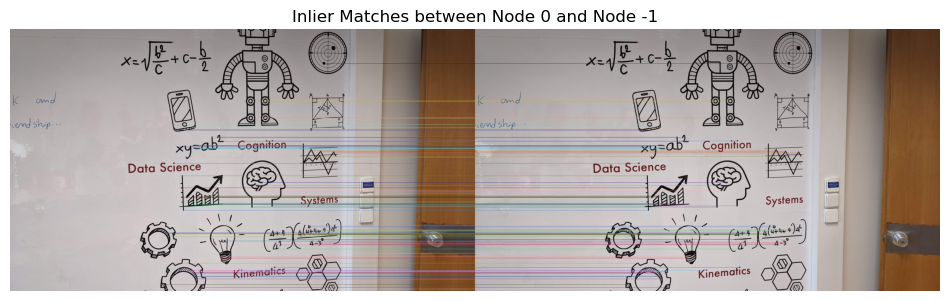

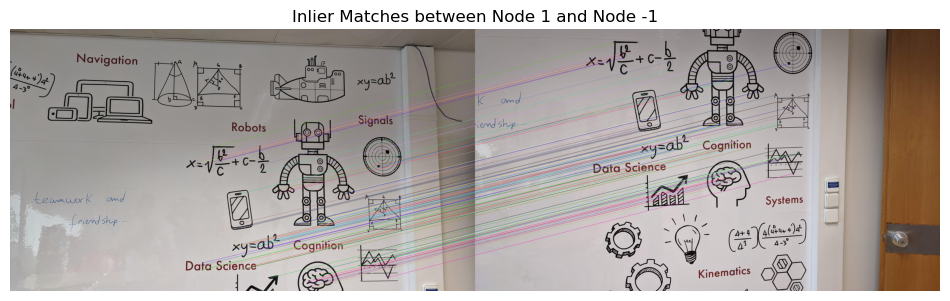

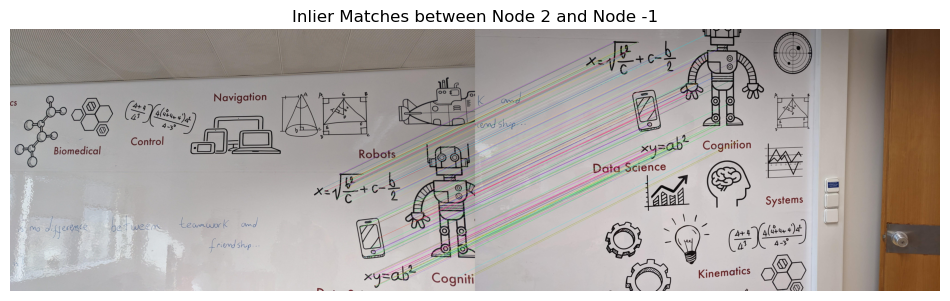

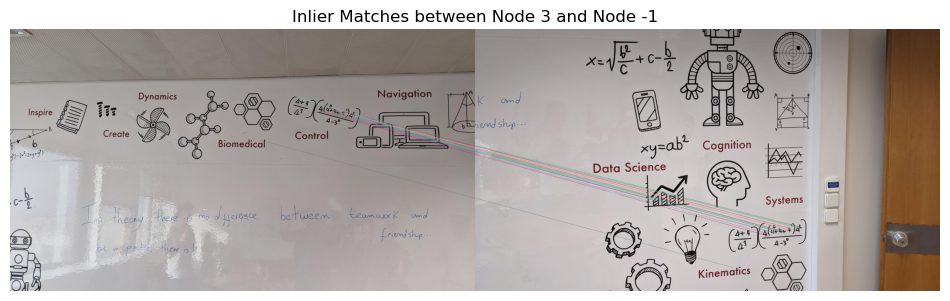

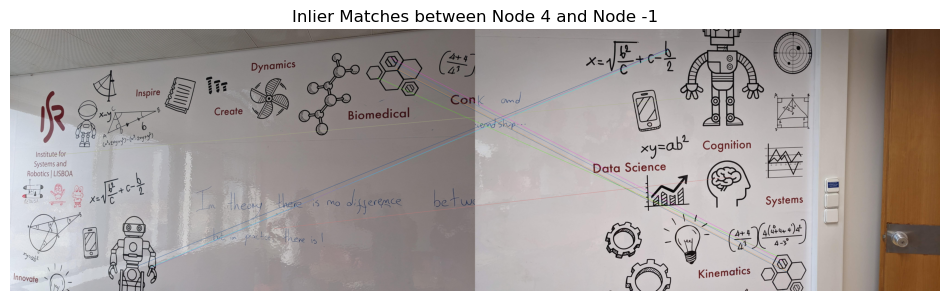

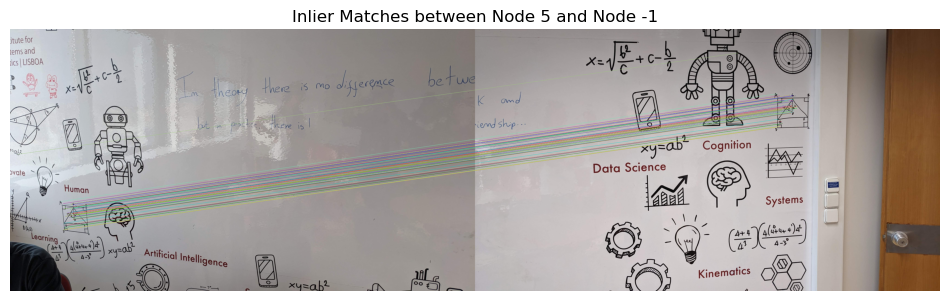

In [26]:
for node in image_nodes[:6]:
    plot_path_inlier_matches(node, 100)

In [18]:
from utils import print_footprints

print_footprints(image_nodes)

[0, 'ref']
[1, 'ref']
[2, 'ref']
[3, 'ref']
[4, 'ref']
[5, 'ref']
[6, 5, 'ref']
[7, 'ref']
[8, 'ref']


In [ ]:
from plot import create_canvas_with_images
final_canvas = create_canvas_with_images(ref_img, image_nodes)
plt.figure(figsize=(20, 20))
plt.imshow(final_canvas)
plt.title("Final Canvas with All Images in Reference Frame")
plt.axis('off')
plt.show()